In [3]:
import pandas as pd
import numpy as np
import psycopg2
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from matplotlib.cbook import boxplot_stats


In [5]:
conn = psycopg2.connect(
    host="localhost",
    database="gastos",
    user="postgres",
    password="postgres")

OperationalError: 

In [45]:
query = '''
select *
from public.gastos
'''

In [46]:
df = pd.read_sql_query(query,con=conn)

In [47]:
df["fvalor"] =pd.to_datetime(df["fvalor"])
df['fvalor_year'] = pd.DatetimeIndex(df['fvalor']).year
df['fvalor_month'] = pd.DatetimeIndex(df['fvalor']).month
df["categoria"] = df["categoria"].str.strip()
df = df.drop("imagen", 1)
df = df.drop("comentario", 1)
#df["subcategoria"] = df["subcategoria"].str.strip()


In [48]:
df = df.set_index("fvalor")

In [58]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 887 entries, 2020-09-14 to 2021-10-01
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   categoria     886 non-null    object 
 1   subcategoria  886 non-null    object 
 2   descripcion   887 non-null    object 
 3   importe       887 non-null    float64
 4   saldo         887 non-null    float64
 5   fvalor_year   887 non-null    int64  
 6   fvalor_month  887 non-null    int64  
dtypes: float64(2), int64(2), object(3)
memory usage: 45.0+ KB


# Fechas de analisis

In [ ]:
filtro = df[(df.index>=  "2019-01-01") & (df.index<=  "2021-09-30") ]

# Suma de gastos por mes y año (con tendencia)

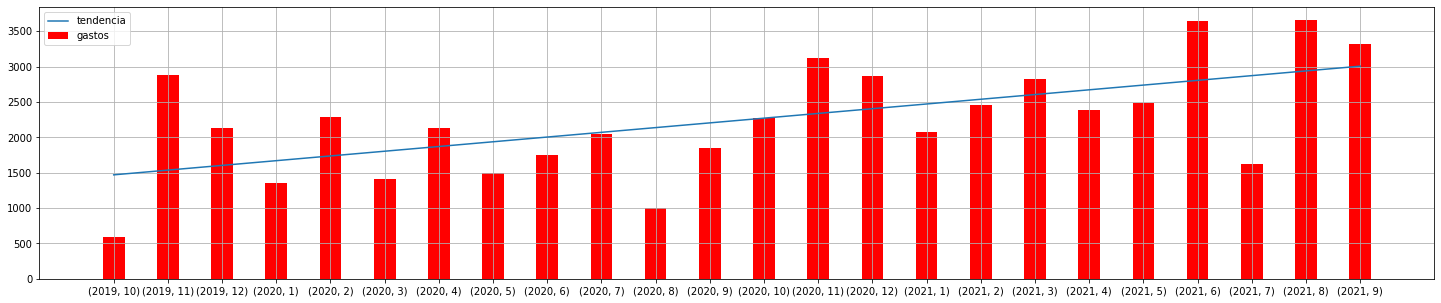

In [59]:
gastos_ac = filtro[filtro.importe<0].groupby(["fvalor_year","fvalor_month"])["importe"].agg("sum").abs()

#Linear regresion fot trend calculation
X = np.arange(len(gastos_ac.index)).reshape(-1, 1)
y = gastos_ac.to_numpy()

lr = LinearRegression()
lr.fit(X, y)
y_pred = lr.predict(X)

#PLOT
plt.figure(figsize=(25,5))
#plt.bar(x=range(len(ingresos_ac.index)), height=ingresos_ac, label="ingresos", color="g", tick_label=ingresos_ac.index,align="edge", width=-0.4)
plt.bar(x=range(len(gastos_ac.index)), height=gastos_ac.abs(), label="gastos", color="r", tick_label=gastos_ac.index, align="center", width=0.4)
plt.plot(X, y_pred, label = "tendencia")
plt.legend()
plt.grid()


# **Comparativa por años de suma de gastos por mes y año**

<AxesSubplot:xlabel='fvalor_month'>

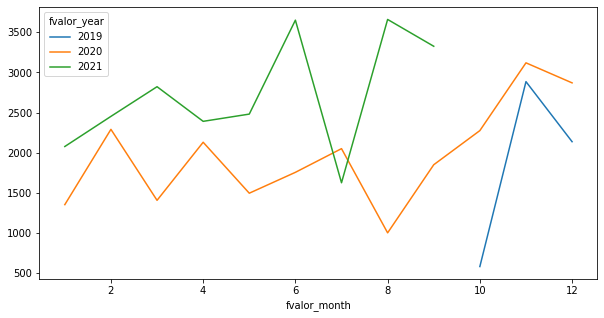

In [55]:
comparativa = filtro[filtro.importe<0].groupby(["fvalor_month","fvalor_year"])["importe"].agg("sum").abs()
comparativa = comparativa.unstack()
comparativa.plot(figsize=(10,5))

**Media mensual de gastos por año**

fvalor_year
2019    1869.490000
2020    1967.962500
2021    2721.668889
Name: importe, dtype: float64


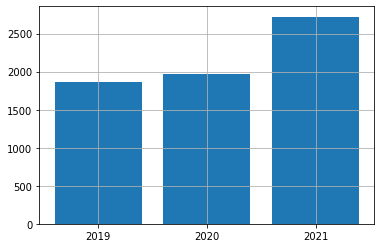

In [57]:
gastos_ac = filtro[filtro.importe<0].groupby(["fvalor_year","fvalor_month"])["importe"].agg("sum").abs()
gastos_ac2 = gastos_ac.groupby(["fvalor_year"]).agg("mean")
plt.bar(gastos_ac2.index,gastos_ac2, tick_label=gastos_ac2.index)
plt.grid()
print(gastos_ac2)

**Desglose por mes y categoria**

In [ ]:
test = filtro[filtro.importe<0].groupby(["fvalor_year","fvalor_month","categoria"])["importe"].agg("sum").abs()
t = test.unstack()
t.plot.bar(figsize=(11,8), colormap="coolwarm", width=0.7, stacked=True)

In [ ]:
test_categoria = filtro[filtro.importe<0].groupby(["categoria","subcategoria","fvalor_year","fvalor_month"])["importe"].agg("sum").abs()
test_hogar = test_categoria.loc["Compras"]
test_hogar = test_hogar.unstack(0)
test_hogar.plot.bar( figsize=(10,10), stacked=True)